In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys  

#extraction and npl
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.cluster import KMeans

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


#forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#bagging
from sklearn.ensemble import BaggingClassifier
#forests
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification

#Knn
from sklearn.neighbors import KNeighborsClassifier



from sklearn.preprocessing import LabelEncoder


from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import datasets

import string

from sklearn.decomposition import PCA

from sklearn.naive_bayes import MultinomialNB


In [2]:
#importing the CSV file with the data
listingFile =pd.read_csv("Listings7.csv",encoding='utf-8')

In [3]:
listingFile.shape

(4390, 8)

In [4]:
listingFile.head(1)

,Unnamed: 0,City Location,Company Name,Degree,Description,Job Title,Search Criteria,Source
0,0,"Cincinnati, OH","Pro4ia, Inc.",user+support,Day-to-day desktop support. Input all service ...,Level 1/2 Desktop Support,user+support,Indeed


In [5]:
listingFile['Degree'].value_counts()

software+development    928
user+support            899
network+manager         872
web+development         864
network+engineer        552
cyber+security          275
Name: Degree, dtype: int64

# Data Cleaning

In [6]:
#now make all words in description lower case
listingFile['CleanDescription']=listingFile['Description'].apply(lambda x: x.lower())

In [7]:
#removing numbers
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

In [8]:
#remove punctuation - code could be more efficient
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace(',',''))
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('.',''))
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('\(',''))
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.replace('\)',''))


In [9]:
#removing numbers from the descriptions
listingFile['CleanDescription']= listingFile['CleanDescription'].apply(lambda x: x.lstrip().replace('\n',''))

In [10]:
#checking to see if any null characters
listingFile.isnull().sum()

Unnamed: 0          0
City Location       0
Company Name        0
Degree              0
Description         0
Job Title           0
Search Criteria     0
Source              0
CleanDescription    0
dtype: int64

In [11]:
#drop duplicates
print listingFile.shape
listingFile=listingFile.drop_duplicates(take_last=True)
print listingFile.shape

(4390, 9)
(4390, 9)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead
  app.launch_new_instance()


In [12]:
listingFile['CleanDescription']

0       day-to-day desktop support input all service r...
1       is seeking a *yardi voyager support specialist...
2       knowledge/experience supporting mobile users s...
3       produce detailed specifications for software r...
4       software development and hardware integration ...
5       advanced html/css development (responsive desi...
6       we are looking for a front-end web designer/de...
7       blue laser design is actively looking to add a...
8       development of enterprise web  applications • ...
9       advanced or formal training in network technol...
10      network services manager support and develop c...
11      as head of ops tech network engineering you wi...
12      field network engineer* integrate with other s...
13      due to our rapid growth lang company is lookin...
14      assists in the development implementation and ...
15      apply knowledge of latest cyber security indus...
16      ability to obtain and maintain a secret securi...
17      the ne

# looking at degrees and graduates

In [13]:
#creating a table of actual degrees and certificates the college awarded per degree
#this is public information
#degree included short term certificates
tempFile =listingFile.groupby('Degree').count()
tempFile=pd.DataFrame(tempFile['Unnamed: 0'])
tempFile.reset_index(inplace=True)

collegeDegreesVSJobs=pd.DataFrame({'DegreeArea': ['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security'],'Number of': [30,71,31,77,79,8]})
collegeDegreesVSJobs.columns=[['Degree', 'Number of Grads']]
collegeDF= pd.merge(collegeDegreesVSJobs, tempFile, on='Degree')
collegeDF.columns=[['Degree', 'Number of Grads', 'Number Listings']]
collegeDF['pctGradsToListing']=collegeDF['Number of Grads']/collegeDF['Number Listings']
collegeDF

,Degree,Number of Grads,Number Listings,pctGradsToListing
0,user+support,30,899,0.033370
1,software+development,71,928,0.076509
2,web+development,31,864,0.035880
3,network+manager,77,872,0.088303
4,network+engineer,79,552,0.143116
5,cyber+security,8,275,0.029091


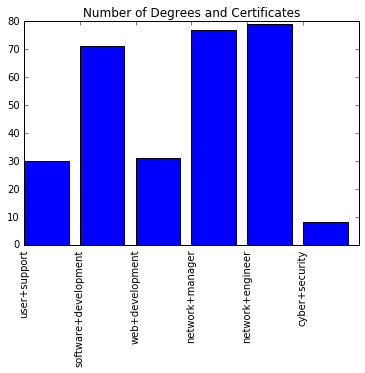

In [14]:
#bar chart
yCollege=collegeDF['Number of Grads']
xCollege=collegeDF['Degree']
plt.bar(range(0, len(xCollege)) ,yCollege)
labels=['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security']

plt.xticks(range(6), labels, rotation='vertical')
plt.title('Number of Degrees and Certificates');



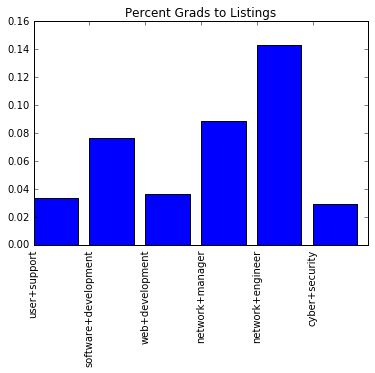

In [15]:
#bar chart
yCollege=collegeDF['pctGradsToListing']
xCollege=collegeDF['Degree']
plt.bar(range(0, len(xCollege)) ,yCollege)
labels=['user+support', 'software+development', 
                         'web+development', 'network+manager', 'network+engineer', 
                         'cyber+security']

plt.xticks(range(6), labels, rotation='vertical')
plt.title('Percent Grads to Listings');

# this is where I would add stemmers lammers
talk with Richard

# Label encoder for degrees

In [16]:
label_encoder = preprocessing.LabelEncoder()
input_classes = ['user+support', 'software+development', 'web+development', 'network+manager',
        'network+engineer', 'cyber+security']
label_encoder.fit(input_classes)


LabelEncoder()

In [17]:
encoded_labels = label_encoder.transform(input_classes)
print "\nLabels =", input_classes 
print "Encoded labels =", list(encoded_labels)


Labels = ['user+support', 'software+development', 'web+development', 'network+manager', 'network+engineer', 'cyber+security']
Encoded labels = [4, 3, 5, 2, 1, 0]


In [18]:
listingFile['encodedDegree']=label_encoder.transform(listingFile['Degree'])

# count vectorizer of the cleanDescription

In [19]:
#will use all words
cvec = CountVectorizer()
v = CountVectorizer(
    binary=True,  
    stop_words='english')
#,max_features=500


In [20]:
wordsDescription = v.fit_transform(listingFile['CleanDescription']).todense()
wordsDescription = pd.DataFrame(wordsDescription, columns=v.get_feature_names())
wordsDescription.shape

(4390, 5588)

In [21]:
wordsDescription.head(1)

,_adaptive,aam,aarp,abb,abbott,abc,abide,abilities,ability,able,...,yes,young,youth,yp,yrs,yslow,zero,zone,zoning,zycron
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# create dummies from the degree to see if words can predict degree

In [22]:
degreeDummies=pd.get_dummies(listingFile['Degree'])
wordDescDegree=pd.DataFrame(wordsDescription).join(pd.DataFrame(degreeDummies))
wordDescDegree.head(1)

,_adaptive,aam,aarp,abb,abbott,abc,abide,abilities,ability,able,...,zero,zone,zoning,zycron,cyber+security,network+engineer,network+manager,software+development,user+support,web+development
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
allDegreeData=pd.DataFrame(listingFile['encodedDegree']).join(pd.DataFrame(listingFile['Degree'])).join(pd.DataFrame(degreeDummies))

In [24]:
allDegreeData.head(1)

,encodedDegree,Degree,cyber+security,network+engineer,network+manager,software+development,user+support,web+development
0,4,user+support,0.0,0.0,0.0,0.0,1.0,0.0


# create train test

In [25]:
wordsDescription.shape , listingFile['encodedDegree'].shape

((4390, 5588), (4390,))

In [26]:
x=wordsDescription
y=listingFile['encodedDegree']

In [27]:
x_train, x_test, y_train, y_test= train_test_split(x.values,y.values, test_size=.4, stratify=y )

In [28]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2633, 5588), (1757, 5588), (2633,), (1757,))

# creating dimension reduction PCA on Train Dataset

In [29]:
pca=PCA(n_components=6)
pca.fit(x_train)
pca.fit_transform(x_train)

array([[-0.76209898,  0.04508528, -0.72629199,  0.34833435, -0.17491112,
         0.04918638],
       [ 0.34324202, -0.23524551, -0.07558991,  0.14764239, -0.06879898,
        -0.23325961],
       [ 0.25748387,  0.87064823,  0.42835624, -0.88113791, -0.08044495,
         0.10682663],
       ..., 
       [ 0.45276716,  0.57082194,  0.02817608,  0.10701471,  0.24890205,
        -0.09839718],
       [-0.5498452 , -0.16398803,  0.18554333,  0.02967691, -0.23449336,
         0.05364998],
       [-0.68075136, -0.11160762,  0.59415525,  0.74686955,  0.36333696,
        -0.00738691]])

In [30]:
pca.get_covariance()

array([[  4.11273713e-03,  -3.55705382e-19,  -4.20833881e-19, ...,
         -2.22688469e-07,  -2.24594565e-07,  -3.78373205e-07],
       [ -3.55705382e-19,   4.10934550e-03,   1.58508306e-31, ...,
         -5.57123308e-20,  -3.93390719e-20,  -1.05232513e-19],
       [ -4.20833881e-19,   1.58508306e-31,   4.10934550e-03, ...,
         -1.46383566e-20,   2.02848185e-20,   4.04582699e-20],
       ..., 
       [ -2.22688469e-07,  -5.57123308e-20,  -1.46383566e-20, ...,
          4.10988141e-03,   2.12352896e-07,   6.22447947e-07],
       [ -2.24594565e-07,  -3.93390719e-20,   2.02848185e-20, ...,
          2.12352896e-07,   4.10970290e-03,   3.03892214e-07],
       [ -3.78373205e-07,  -1.05232513e-19,   4.04582699e-20, ...,
          6.22447947e-07,   3.03892214e-07,   4.11011976e-03]])

In [31]:
pca.explained_variance_

array([ 0.43758618,  0.25329731,  0.19705428,  0.16678309,  0.13422703,
        0.1232178 ])

In [32]:
train_features=pca.fit_transform(x_train)

# lets try random forest with full dataset and pca
on train test data
1. using full data set without train test
2. using PCA

In [33]:
y=LabelEncoder().fit_transform(listingFile['Degree'])
cv = StratifiedKFold(y, n_folds=4, shuffle=True, random_state=41)
print type(y), y[0:6]
print type(x)

<type 'numpy.ndarray'> [4 4 4 3 3 3]
<class 'pandas.core.frame.DataFrame'>


In [34]:
x.shape, y.shape


((4390, 5588), (4390,))

In [35]:
rf=RandomForestClassifier(class_weight ='balanced', n_jobs=-1)
s=cross_val_score(rf,x.values,y,cv=cv, n_jobs=-1)


In [36]:
s

array([ 0.81147541,  0.81785064,  0.80601093,  0.79105839])

In [37]:
rf.fit(x, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [130]:
rf.score(x, y)

0.97722095671981779

In [38]:
# for f in range(x.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

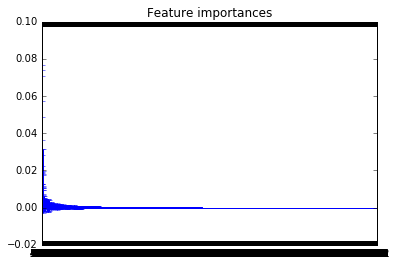

In [39]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [40]:
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [41]:
feature_importancesRF.head(10)

,importance
security,0.060706
software,0.048000
development,0.046300
support,0.041832
web,0.031086
manager,0.030535
network,0.022137
user,0.020494
users,0.015374
cyber,0.014218


In [42]:
predictionsRF=rf.predict(x)

In [43]:
print confusion_matrix(y, predictionsRF)

[[274   1   0   0   0   0]
 [  0 542   6   3   1   0]
 [  1  20 850   0   1   0]
 [  1   0   0 902   1  24]
 [  0   0   0   2 897   0]
 [  2   0   2  34   1 825]]


In [44]:
conmat = np.array(confusion_matrix(y, predictionsRF))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion


      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU        274          1          0          0          0          0
SODE          0        542          6          3          1          0
WEDE          1         20        850          0          1          0
NEMA          1          0          0        902          1         24
NEED          0          0          0          2        897          0
CYIT          2          0          2         34          1        825


In [45]:
print  classification_report(y, predictionsRF)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       275
          1       0.96      0.98      0.97       552
          2       0.99      0.97      0.98       872
          3       0.96      0.97      0.97       928
          4       1.00      1.00      1.00       899
          5       0.97      0.95      0.96       864

avg / total       0.98      0.98      0.98      4390



# random forest by degree - want feature importance

In [146]:
wordDescDegree.columns

Index([u'_adaptive', u'aam', u'aarp', u'abb', u'abbott', u'abc', u'abide',
       u'abilities', u'ability', u'able',
       ...
       u'zero', u'zone', u'zoning', u'zycron', u'cyber+security',
       u'network+engineer', u'network+manager', u'software+development',
       u'user+support', u'web+development'],
      dtype='object', length=5594)

In [150]:
yCYIT=wordDescDegree['cyber+security']
yNEEN=wordDescDegree['network+engineer']
yNEMA=wordDescDegree['network+manager']
ySODE=wordDescDegree['software+development']
yUSSU=wordDescDegree['user+support']
yWEDE=wordDescDegree['web+development']

0.997038724374
              importance
security        0.189719
cyber           0.066780
development     0.028334
information     0.024714
software        0.023879
web             0.019224
support         0.014368
privately       0.011276
cissp           0.010145
intelligence    0.009916


In [159]:
yDegree=yNEEN
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(20)

0.98701594533
                importance
network           0.112507
engineer          0.041250
manager           0.031904
engineers         0.031448
implementation    0.026109
networks          0.025230
development       0.021122
web               0.016949
user              0.016167
software          0.009821
support           0.007564
controls          0.004900
users             0.004416
infrastructure    0.004247
storage           0.004067
technical         0.003837
systems           0.003756
possibility       0.003635
provides          0.003616
applications      0.003500


In [154]:
yDegree=yNEMA
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(10)

0.991571753986
             importance
manager        0.165712
network        0.075594
development    0.056612
web            0.020033
managers       0.018360
experience     0.015571
user           0.015559
support        0.014955
software       0.012433
engineer       0.011336


In [155]:
yDegree=ySODE
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(10)

0.984965831435
             importance
development    0.133971
software       0.076869
manager        0.044995
network        0.039563
web            0.030268
experience     0.013661
support        0.011621
security       0.011494
networks       0.010241
users          0.010124


In [156]:
yDegree=yUSSU
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(10)

0.997949886105
             importance
support        0.283741
user           0.083932
development    0.041507
users          0.031067
manager        0.019090
software       0.015296
web            0.014177
provide        0.012543
network        0.011964
supports       0.010110


In [158]:
yDegree=yWEDE
rf.fit(x, yDegree)
rf.score(x, yDegree)
importances = rf.feature_importances_
feature_importancesRF = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print rf.score(x, yDegree)
print feature_importancesRF.head(10)

0.984510250569
             importance
web            0.157577
development    0.132000
software       0.022475
network        0.020562
experience     0.020235
manager        0.014050
engineer       0.009273
support        0.008071
application    0.007535
hardware       0.007420


# RF to train test

In [ ]:
# x = train_features=pca.fit_transform(x_train)

In [ ]:
train_features=pca.fit_transform(x_train)

In [134]:
x_train.shape, train_features.shape,y_train.shape


((2633, 5588), (2633, 6), (2633,))

In [135]:
rfTTS=RandomForestClassifier(class_weight ='balanced', n_jobs=-1)
sTTS=cross_val_score(rf,train_features,y_train,cv=cv, n_jobs=-1)

In [136]:
cv = StratifiedKFold(y_train, n_folds=4, shuffle=True, random_state=41)

In [137]:
s

array([ 0.80786687,  0.77996965,  0.77355623,  0.77099237])

In [138]:
rfTTS.fit(train_features, y_train)
importances = rfTTS.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [139]:
rfTTS.score(train_features, y_train)

0.97683251044436004

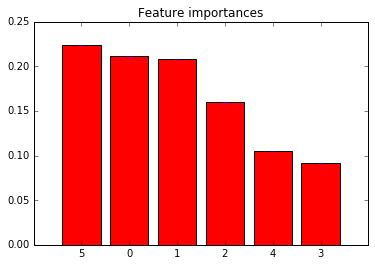

In [140]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), indices)
plt.xlim([-1, train_features.shape[1]])
plt.show()

# RF model built with PCA test data

In [59]:
train_features.shape, x_test.shape


((2633, 6), (1757, 5588))

In [64]:
test_features=pca.transform(x_test)

In [141]:
rfTTS.score(test_features, y_test)

0.79282868525896411

In [65]:
predictionsRF_test=rfTTS.predict(test_features)

In [66]:
y_test.shape, predictionsRF_test.shape

((1757,), (1757,))

In [67]:
print confusion_matrix(y_test, predictionsRF_test)

[[ 86   8   7   4   3   2]
 [ 14 143  32  10  14   8]
 [  5  34 303   2   1   4]
 [  3   4   4 292  12  56]
 [  3   9  14   8 320   6]
 [  1   4   7  70   5 259]]


In [68]:
conmat = np.array(confusion_matrix(y_test, predictionsRF_test))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion

      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU         86          8          7          4          3          2
SODE         14        143         32         10         14          8
WEDE          5         34        303          2          1          4
NEMA          3          4          4        292         12         56
NEED          3          9         14          8        320          6
CYIT          1          4          7         70          5        259


# KNn  entire dataset


In [69]:
x=wordsDescription

In [70]:
y=listingFile['encodedDegree']
y.column='degree'

In [71]:
knn=KNeighborsClassifier(n_neighbors=5)
#5 closest neighbors

In [72]:
knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [73]:
knn.score(x,y)

0.81435079726651483

In [74]:
scores=cross_val_score(knn,x.values,y,cv=5,scoring = 'accuracy')

In [75]:
predictionsKNN=knn.predict(x)

In [76]:
print confusion_matrix(y, predictionsKNN)

[[249   3  10   8   1   4]
 [ 37 420  42  40  11   2]
 [ 21  51 774  11   6   9]
 [  4   2   7 860   8  47]
 [ 25  16  59  92 698   9]
 [  9   5  11 257   8 574]]


In [77]:
conmat = np.array(confusion_matrix(y, predictionsKNN))
confusion = pd.DataFrame(conmat, index=['USSU', 'SODE', 
                         'WEDE', 'NEMA','NEED', 'CYIT'],columns=['Pred USSU', 'Pred SODE', 
                         'Pred WEDE', 'Pred NEMA','Pred NEED', 'Pred CYIT'])
print confusion

      Pred USSU  Pred SODE  Pred WEDE  Pred NEMA  Pred NEED  Pred CYIT
USSU        249          3         10          8          1          4
SODE         37        420         42         40         11          2
WEDE         21         51        774         11          6          9
NEMA          4          2          7        860          8         47
NEED         25         16         59         92        698          9
CYIT          9          5         11        257          8        574


In [78]:
print  classification_report(y, predictionsKNN)

             precision    recall  f1-score   support

          0       0.72      0.91      0.80       275
          1       0.85      0.76      0.80       552
          2       0.86      0.89      0.87       872
          3       0.68      0.93      0.78       928
          4       0.95      0.78      0.86       899
          5       0.89      0.66      0.76       864

avg / total       0.84      0.81      0.81      4390



# Knn on PCA training set 

In [81]:
knnTTS=KNeighborsClassifier(n_neighbors=5)

In [82]:
knnTTS.fit(train_features,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [83]:
knnTTS.score(train_features,y_train)

0.85225977971895173

In [84]:
predictionsKNN=knnTTS.predict(train_features)

In [85]:
print confusion_matrix(y_train, predictionsKNN)

[[125  11  11   5   9   4]
 [ 11 240  45  15  15   5]
 [  5  31 470   6   7   4]
 [  5   6   4 474  10  58]
 [  4   7  10  17 490  11]
 [  1   5   5  58   4 445]]


# Knn on test data after being trained on training data

In [86]:
test_featuresKNN_TTS=pca.transform(x_test)

In [143]:
knnTTS.score(test_features,y_test)

0.78429140580535006

In [89]:
predictionsKNN_TTS=knnTTS.predict(test_featuresKNN_TTS)

In [91]:
print confusion_matrix(y_test, predictionsKNN_TTS)

[[ 86   7   8   5   2   2]
 [ 11 137  39  15  14   5]
 [  3  36 298   2   5   5]
 [  5   7   4 288  10  57]
 [  6  11  11   9 308  15]
 [  0   9   8  61   7 261]]


# Naive Bayes for clustering not going to use

In [ ]:
mnb=MultinomialNB()

In [ ]:
mnb.fit(x,y)

In [ ]:
mnb.score(x,y)

In [ ]:
y_hat=mnb.predict(x)

In [ ]:
print classification_report(y, y_hat)

In [ ]:
confusion_matrix(y,y_hat)

In [ ]:
predicted_probabilities=mnb.predict_proba(x)
predicted_probabilities[0:5]

# K means

In [95]:
kmeans=KMeans(6)
kmeans.fit(x)
predicts=kmeans.predict(x)

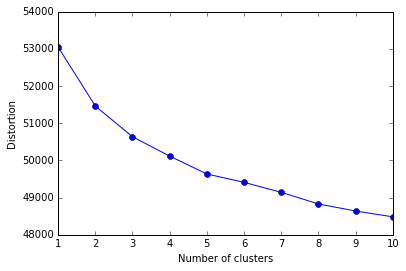

In [97]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [118]:
df = pd.DataFrame(x, columns=wordsDescription.columns)
df.head()

,_adaptive,aam,aarp,abb,abbott,abc,abide,abilities,ability,able,...,yes,young,youth,yp,yrs,yslow,zero,zone,zoning,zycron
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
type(listingFile)

pandas.core.frame.DataFrame

In [123]:
df.shape

(4390, 5589)

In [128]:
df = listingFile.join(
    pd.DataFrame(kmeans.predict(x), 
                 columns=['predictions_k6'])
)

In [129]:
df.head()

,Unnamed: 0,City Location,Company Name,Degree,Description,Job Title,Search Criteria,Source,CleanDescription,encodedDegree,predictions_k6
0,0,"Cincinnati, OH","Pro4ia, Inc.",user+support,Day-to-day desktop support. Input all service ...,Level 1/2 Desktop Support,user+support,Indeed,day-to-day desktop support input all service r...,4,5
1,1,"Columbus, OH 43215","The Woda Group, Inc.",user+support,", is seeking a *Yardi Voyager Support Speciali...",Yardi Voyager Support Specialist,user+support,Indeed,is seeking a *yardi voyager support specialist...,4,5
2,2,"Fort Wayne, IN","ENS Group, Inc.",user+support,Knowledge/experience supporting mobile users. ...,Service Desk Technician,user+support,Indeed,knowledge/experience supporting mobile users s...,4,5
3,12,"Dayton, OH",Riverside Research,software+development,Produce detailed specifications for software r...,Software Developer,software+development,Indeed,produce detailed specifications for software r...,3,1
4,13,"Wright-Patterson AFB, OH",Riverside Research,software+development,Software development and hardware integration ...,Software Engineer,software+development,Indeed,software development and hardware integration ...,3,3


In [162]:
resultsOFClustering=df[['Degree','Search Criteria','encodedDegree','predictions_k6']]

In [164]:
resultsOFClustering.head(1)

,Degree,Search Criteria,encodedDegree,predictions_k6
0,user+support,user+support,4,5


# Visualizing the data with TSNE

In [109]:
from sklearn.manifold import TSNE

In [110]:
tsne = TSNE()

In [111]:
graphing_data = tsne.fit_transform(x)

In [112]:
graphing_data[0:5]

array([[ 0.44831419, -4.61897474],
       [-1.58269683, -8.14145554],
       [ 4.30389753, -8.03383633],
       [ 7.34888463,  1.67914779],
       [ 9.3656817 ,  3.38267913]])

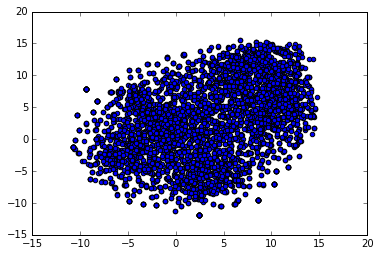

In [113]:
plt.scatter(graphing_data[:,0], graphing_data[:,1])

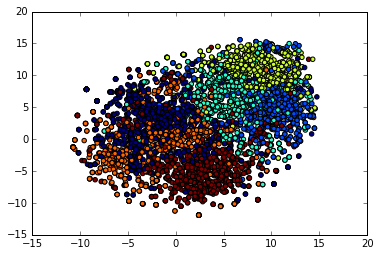

In [115]:
plt.scatter(graphing_data[:,0], graphing_data[:,1],
           c=kmeans.predict(x)) 